# Finding Strong Lenses in DC2 Run 3.1i

This notebook shows how to find strong lenses in the processed `calexp` images.

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
%matplotlib inline

## Load Truth Catalogs

The truth catalogs contain the locations of the strongly lensed AGN and SNe that we added into the DDF. They are sqlite files that can be loaded as pandas dataframes.

In [2]:
# Use sqlalchemy and pandas to load sqlite truth tables
truth_db_folder = '/global/cfs/cdirs/descssim/DC2/Run3.0i/truth_tables'
lensed_agn_truth_file = os.path.join(truth_db_folder, 'updated_lensed_agn_truth.db')
engine = create_engine('sqlite:///%s' % lensed_agn_truth_file, echo=False)

For this demo notebook we will look for strongly lensed AGN since they are always "on" and if we pick any visit they will be present. The lensed SNe will require comparing `t0` to the visit mjd.

In [3]:
lensed_agn_truth_df = pd.read_sql('lensed_agn', con=engine)

Here is a sample of the complete truth table and the column labels. The relevant columns will be the `unique_id`, `ra`, and `dec` but we can also include the quiescent flux values of the AGN to try to find brighter AGN for this test.

In [4]:
print(lensed_agn_truth_df.columns)

Index(['index', 'unique_id', 'ra', 'dec', 'x_agn', 'y_agn', 'x_img', 'y_img',
       'redshift', 't_delay', 'magnorm', 'flux_u_agn', 'flux_g_agn',
       'flux_r_agn', 'flux_i_agn', 'flux_z_agn', 'flux_y_agn',
       'flux_u_agn_noMW', 'flux_g_agn_noMW', 'flux_r_agn_noMW',
       'flux_i_agn_noMW', 'flux_z_agn_noMW', 'flux_y_agn_noMW',
       'magnification', 'seed', 'agn_tau_u', 'agn_tau_g', 'agn_tau_r',
       'agn_tau_i', 'agn_tau_z', 'agn_tau_y', 'agn_sf_u', 'agn_sf_g',
       'agn_sf_r', 'agn_sf_i', 'agn_sf_z', 'agn_sf_y', 'av_mw', 'rv_mw',
       'lens_id', 'dc2_sys_id', 'lens_cat_sys_id', 'image_number',
       'total_magnification'],
      dtype='object')


In [5]:
lensed_agn_truth_df.head()

,index,unique_id,ra,dec,x_agn,y_agn,x_img,y_img,redshift,t_delay,...,agn_sf_i,agn_sf_z,agn_sf_y,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number,total_magnification
0,0,GLAGN_0_0,53.494374,-28.283800,-0.165630,0.112272,0.1132,-0.0756,1.06,0.000000,...,0.5863,0.5474,0.5190,0.032723,3.1,2.562505e+09,GLAGN_0,115074,0,2.949166
1,0,GLAGN_0_1,53.494201,-28.283683,-0.165630,0.112272,0.1132,-0.0756,1.06,-2.432431,...,0.5863,0.5474,0.5190,0.032723,3.1,2.562505e+09,GLAGN_0,115074,1,2.949166
2,2,GLAGN_1_0,52.566912,-27.584574,0.222652,0.487403,-0.5457,-0.9090,2.08,0.000000,...,0.3189,0.2975,0.2818,0.027206,3.1,1.875009e+09,GLAGN_1,125027,0,5.024002
3,2,GLAGN_1_1,52.567168,-27.583733,0.222652,0.487403,-0.5457,-0.9090,2.08,-28.796382,...,0.3189,0.2975,0.2818,0.027206,3.1,1.875009e+09,GLAGN_1,125027,1,5.024002
4,4,GLAGN_2_0,53.642295,-28.561889,-0.210878,0.161722,0.4150,-0.3968,2.89,0.000000,...,0.3927,0.3671,0.3482,0.022477,3.1,2.562528e+09,GLAGN_2,394519,0,4.991128


## Load Images

Now let's use the dm `butler` to load up calibrated exposures `calexp`s of the same visit from Run 2.2i and Run 3.1i so that we can compare the static-only Run 2.2 image with the images of Run 3.1i which contain our extra time-domain objects.

In [6]:
import lsst.geom
import lsst.daf.persistence as dp

In [7]:
run_3p1_butler = dp.Butler('/global/cfs/cdirs/lsst/production/DC2_ImSim/Run3.1i/desc_dm_drp/v19.0.0-v1/rerun/run3.1i-calexp-v1')

In [8]:
data_id = {'visit': 159496, 'raftName': 'R11', 'detectorName': 'S02'}
run_3p1_calexp = run_3p1_butler.get('calexp', **data_id)

In [9]:
run_2p2_butler = dp.Butler('/global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1')

In [10]:
run_2p2_calexp = run_2p2_butler.get('calexp', **data_id)

#### Show off a full image from this detector

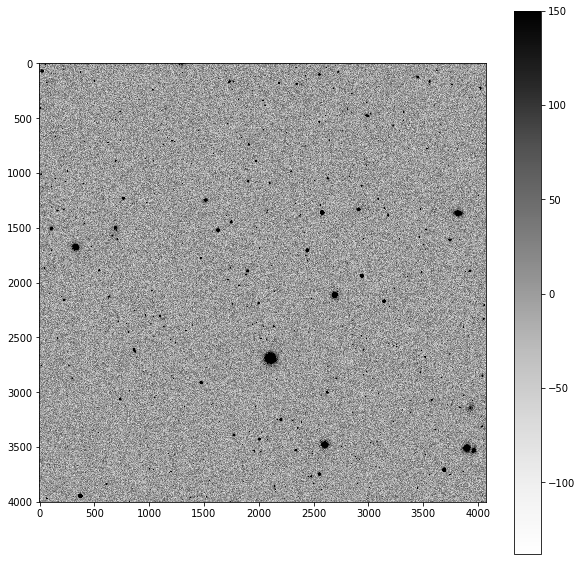

In [19]:
fig = plt.figure(figsize=(10,10))
plt.imshow(run_3p1_calexp.image.array, cmap=plt.get_cmap('Greys'), vmax=150)
plt.colorbar()

#### Load the WCS and find lensed AGN systems on chip

In [20]:
w = run_3p1_calexp.getWcs()

In [31]:
x_pixel_list = []
y_pixel_list = []
for ra, dec in lensed_agn_truth_df[['ra', 'dec']].values:
    pt_pixel = w.skyToPixel(lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees))
    x_pixel_list.append(pt_pixel[0])
    y_pixel_list.append(pt_pixel[1])

In [32]:
lensed_agn_truth_df['x_pixel'] = x_pixel_list
lensed_agn_truth_df['y_pixel'] = y_pixel_list

In [36]:
sensor_agn_df = lensed_agn_truth_df.query('x_pixel > 0 and x_pixel < 4000 and y_pixel > 0 and y_pixel < 4000')

In [38]:
sensor_agn_df.head()

,index,unique_id,ra,dec,x_agn,y_agn,x_img,y_img,redshift,t_delay,...,agn_sf_y,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number,total_magnification,x_pixel,y_pixel
30,30,GLAGN_14_0,53.588253,-27.805512,0.710894,-0.419521,1.3158,-1.3654,2.06,0.000000,...,0.08081,0.026034,3.1,2.562564e+09,GLAGN_14,892663,0,2.883821,1732.118730,173.971724
31,30,GLAGN_14_1,53.587728,-27.805071,0.710894,-0.419521,1.3158,-1.3654,2.06,69.107302,...,0.08081,0.026034,3.1,2.562564e+09,GLAGN_14,892663,1,2.883821,1740.936857,166.560768
118,118,GLAGN_48_0,53.731872,-27.774848,0.001333,0.054156,0.0191,0.3554,2.40,0.000000,...,0.37520,0.029671,3.1,2.563828e+09,GLAGN_48,16336796,0,27.337722,2021.150772,2509.376344
119,118,GLAGN_48_1,53.731929,-27.774824,0.001333,0.054156,0.0191,0.3554,2.40,0.121608,...,0.37520,0.029671,3.1,2.563828e+09,GLAGN_48,16336796,1,27.337722,2021.470799,2510.333045
120,118,GLAGN_48_2,53.731813,-27.774821,0.001333,0.054156,0.0191,0.3554,2.40,0.157141,...,0.37520,0.029671,3.1,2.563828e+09,GLAGN_48,16336796,2,27.337722,2021.747485,2508.504687


In [42]:
unique_systems = np.unique(sensor_agn_df['dc2_sys_id'])
print(unique_systems, len(unique_systems))

['GLAGN_100' 'GLAGN_1003' 'GLAGN_1004' 'GLAGN_1013' 'GLAGN_14' 'GLAGN_153'
 'GLAGN_169' 'GLAGN_181' 'GLAGN_204' 'GLAGN_210' 'GLAGN_299' 'GLAGN_361'
 'GLAGN_437' 'GLAGN_439' 'GLAGN_461' 'GLAGN_48' 'GLAGN_512' 'GLAGN_535'
 'GLAGN_596' 'GLAGN_616' 'GLAGN_650' 'GLAGN_661' 'GLAGN_69' 'GLAGN_711'
 'GLAGN_856' 'GLAGN_867' 'GLAGN_872' 'GLAGN_887' 'GLAGN_922' 'GLAGN_924'
 'GLAGN_971' 'GLAGN_978'] 32


Great! We have 32 unique lensed AGN available on this detector! Let's go find one!

## Displaying the image and truth positions

Let's sort by the quiescent flux of the lensed AGN images to try to find one of the brighter ones to make sure we can see it without difference imaging.

In [82]:
sorted_cat_by_flux = sensor_agn_df.sort_values(['flux_g_agn'], ascending=False)[['unique_id', 'ra', 'dec', 'flux_g_agn', 'x_pixel', 'y_pixel', 'dc2_sys_id']]

In [83]:
# Transpose to get x and y pixels correct
full_sensor_3p1 = run_3p1_calexp.image.array.T
full_sensor_2p2 = run_2p2_calexp.image.array.T

In [84]:
# Pick a target from the catalog
u_id, ra, dec, g_flux, x_pix, y_pix, sys_id = sorted_cat_by_flux.iloc[2].values
print(u_id, g_flux, x_pix, y_pix, sys_id)

# Pick out the location of all images in the system
glagn_sample_sys = sensor_agn_df.query('dc2_sys_id == "%s"' % sys_id)

GLAGN_210_0 3.2930594090359025e-05 1511.962216952714 1243.6128107488476 GLAGN_210


In [85]:
# Set image width in pixels
x_width = 30
y_width = 30

Text(0.5, 1.0, 'Run 3.1i Image')

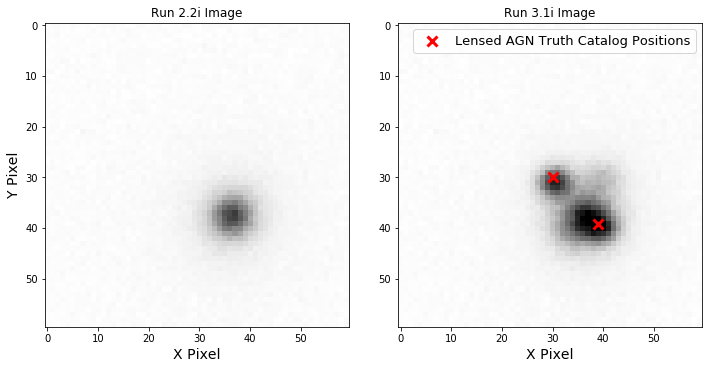

In [81]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(full_sensor_2p2[int(x_pix - x_width):int(x_pix + x_width),
                   int(y_pix - y_width):int(y_pix + y_width)], vmax=2500, vmin=-50,
       cmap=plt.get_cmap('Greys'))
#colorbar()
plt.title('Run 2.2i Image')
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)

fig.add_subplot(1,2,2)
plt.imshow(full_sensor_3p1[int(x_pix - x_width):int(x_pix + x_width),
           int(y_pix - y_width):int(y_pix + y_width)], vmax=2500, vmin=-50,
       cmap=plt.get_cmap('Greys'))
plt.scatter(glagn_sample_sys['x_pixel']-(x_pix-x_width), 
            glagn_sample_sys['y_pixel']-(y_pix-y_width), c='r', marker='x', s=100,
            lw=3, label='Lensed AGN Truth Catalog Positions')
plt.xlabel('X Pixel', size=14)
plt.legend(fontsize=13)
#colorbar()

plt.tight_layout()
plt.title('Run 3.1i Image')

In [86]:
glagn_sample_sys

,index,unique_id,ra,dec,x_agn,y_agn,x_img,y_img,redshift,t_delay,...,agn_sf_y,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number,total_magnification,x_pixel,y_pixel
493,492,GLAGN_210_0,53.656561,-27.810949,-0.289019,-0.348485,-0.9534,-1.4066,1.28,0.000000,...,0.2739,0.028831,3.1,2.562516e+09,GLAGN_210,262229,0,5.284048,1511.962217,1243.612811
494,492,GLAGN_210_1,53.657075,-27.810399,-0.289019,-0.348485,-0.9534,-1.4066,1.28,27.749973,...,0.2739,0.028831,3.1,2.562516e+09,GLAGN_210,262229,1,5.284048,1520.864498,1252.875601


Cool! We plotted the image of the doubly lensed system in Run 3.1i on the right comparing the Run 2.2i image on the left that only contains the static lens galaxy.